#### *Sofia Noemi Crobeddu - Sapienza University // Université Paris-Est Créteil (UPEC)*
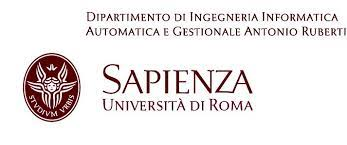 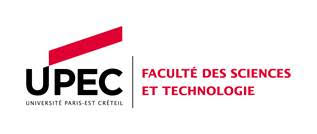

# Inception version V1: Classification for CIFAR-100

In this project I am building and training a deep learning model to classify images from the CIFAR-100 dataset using Inception V1 architecture.
The **CIFAR-100 dataset** includes 50,000 training images and 10,000 test/validation images, each of size 32x32 pixels with 3 color channels (RGB).

- Model Overview: Inception V1 architecture uses multiple convolutional layers with different filter sizes (1x1, 3x3, 5x5) to extract features at various levels of abstraction. It also incorporates auxiliary classifiers, which are additional classifiers inserted at intermediate layers during training. These auxiliary classifiers help with gradient flow and assist in faster convergence, particularly in very deep networks.
- In my implementation the model has three outputs:
  - Main output (*Y_pred[0]*): primary classification output, which gives the predicted class probabilities for each image in the CIFAR-100 dataset.
  - Auxiliary outputs (*Y_pred[1] and Y_pred[2]*): additional outputs used only during training to optimize the model's performance. These outputs help improve gradient propagation throughout the network.
- There are also 7 inception modules. For datasets like CIFAR-10, the modules are usually 9, but in this case it was too complex computationally to perform.
- The model is compiled with the SGD optimizer and uses categorical cross-entropy loss since this is a multi-class classification task.

## Inception module - naive version:

```mermaid
graph TD
    A[Previous layer] --> B[1x1 convolutions]
    A --> C[3x3 convolutions]
    A --> D[5x5 convolutions]
    A --> E[3x3 max pooling]
    B --> F[Filter concatenation]
    C --> F
    D --> F
    E --> F

    %% Nodes and text color
    style A fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
    style B fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style C fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style D fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style E fill:#F6A6B2,stroke:#000,stroke-width:2px, color:#000
    style F fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
```

## Inception module with dimension reduction:

```mermaid
graph TD
    A[Previous layer] --> B[1x1 convolutions]
    A --> C[1x1 convolutions]
    A --> D[1x1 convolutions]
    A --> E[3x3 max pooling]
    C --> F[3x3 convolutions]
    D --> G[5x5 convolutions]
    E --> H[1x1 convolutions]
    B --> I[Filter concatenation]
    F --> I
    G --> I
    H --> I

    %% Nodes and text color
    style A fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
    style B fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style C fill:#FFFF99,stroke:#000,stroke-width:2px, color:#000
    style D fill:#FFFF99,stroke:#000,stroke-width:2px, color:#000
    style E fill:#F6A6B2,stroke:#000,stroke-width:2px, color:#000
    style F fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style G fill:#A9D0F5,stroke:#000,stroke-width:2px, color:#000
    style H fill:#FFFF99,stroke:#000,stroke-width:2px, color:#000
    style I fill:#A8D5BA,stroke:#000,stroke-width:2px, color:#000
```

In [ ]:
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Input, concatenate, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Inception module with reduction:
This function defines the **inception module** for a Convolutional Neural Network (CNN). It is designed to extract features at multiple scales and learn more complex representations by combining several types of convolutions and a pooling layer in parallel. The idea at the base is inspired by Google's Inception architecture, which enhances the capacity of CNNs while controlling computational cost. This function is made to process data into multiple paths.

- In the first 1x1 Convolution branch the goal is to reduce the number of feature maps (dimensionality reduction) and extracts features with minimal computation.
- Second Branch: 1x1 Convolution to reduce dimensionality + 3x3 Convolution for feature extraction. This allows the network to capture features at a medium-sized receptive field while controlling the computational cost.
- Third Branch: 1x1 Convolution to reduce dimensionality + 5x5 Convolution to capture larger-scale features due to the larger receptive field provided by the 5x5 kernel.
- Fourth Branch: Pooling operation that helps aggregate spatial information + 1x1 Convolution to have the pooled output in a smaller dimension.
- Finally, concatenation.

Also: 
- the **Batch Normalization** is used after each convolution to stabilize training by normalizing the activations;
- **padding='same'** ensures that the output feature map has the same spatial dimensions as the input;
- **Regularization** through **L2** to the convolutional layers to prevent overfitting.
- **Activation funcion** is **ReLU** that introduces non-linearity, helping the model to learn complex patterns.

In [2]:
#Inception module with Batch Normalization
def inception_module(x, f1, f3_r, f3, f5_r, f5, proj):
    #1x1 Convolution Branch:
    #This branch performs a 1x1 convolution to reduce dimensionality and extract features.
    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(x)
    conv1 = BatchNormalization()(conv1) #Normalizing activations to improve training stability.
    
    #1x1 Convolution followed by 3x3 Convolution Branch:
    #The 1x1 convolution reduces dimensionality. After that, the 3x3 convolution extracts features.
    conv3 = Conv2D(f3_r, (1, 1), padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(x)
    conv3 = BatchNormalization()(conv3) #Normalizing the output of the 1x1 convolution.
    conv3 = Conv2D(f3, (3, 3), padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(conv3)
    conv3 = BatchNormalization()(conv3) #Normalizing the output of the 3x3 convolution.
    
    #1x1 Convolution followed by 5x5 Convolution Branch:
    #The 1x1 convolution reduces dimensionality. After that, the 5x5 convolution captures larger features.
    conv5 = Conv2D(f5_r, (1, 1), padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(x)
    conv5 = BatchNormalization()(conv5) #Normalizing the output of the 1x1 convolution.
    conv5 = Conv2D(f5, (5, 5), padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(conv5)
    conv5 = BatchNormalization()(conv5) #Normalizing the output of the 5x5 convolution.
    
    #3x3 Max Pooling followed by 1x1 Convolution Branch:
    #This branch applies max pooling to reduce spatial dimensions and after that, uses a 1x1 convolution for feature extraction.
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(proj, (1, 1), padding='same', activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01))(pool_proj)
    pool_proj = BatchNormalization()(pool_proj) #Normalizing the output of the pooling and convolution combination.
    
    #Concatenating the outputs from all branches along the channel dimension.
    output = concatenate([conv1, conv3, conv5, pool_proj], axis=-1)
    return output

### Auxiliary classifier:
This function defines an auxiliary classifier (often used in deep CNN), to help to stabilize training by providing intermediate supervision. This auxiliary branch is used to avoid vanishing gradients, and allows gradients to be propagated more smoothly during the training. The classifier consists of a small convolutional layer, followed by fully connected **dense layers**, **batch normalization**, and **Dropout** that puts 30% of units to 0 during training (i.e. deactivation), reducing overfitting by preventing co-adaptation of units.

In particular:
- the **Average Pooling Layer** is used to reduce the spatial dimensions of the input feature map to make it more manageable for the subsequent layers. The pooling operation aggregates information and helps reduce overfitting.
- **Flatten** transforms the 2D feature map into a 1D vector, preparing it for the fully connected layer.
- **Dense(num_classes, activation='softmax')** applies the softmax activation for multi-class classification, producing probabilities for each class.

Also: **Regularization L2** is used again to penalize large weights, aiding in reducing overfitting.

In [3]:
#Auxiliar classificator with Batch Normalization
def auxiliary_classifier(x, num_classes):
    #Applying average pooling to reduce spatial dimensions while retaining information.
    x = AveragePooling2D((5, 5), strides=3, padding='same')(x)
    
    #1x1 Convolution to reduce the number of feature maps and introduce non-linearity.
    x = Conv2D(128, (1, 1), padding='same', activation='relu', 
               kernel_regularizer=regularizers.l2(0.01))(x) #this operation reduces the number of channels to 128. ReLU introduces non-linearity.
    x = BatchNormalization()(x)  #Normalizing to stabilize training and speed up convergence.
    
    #Flatten the output to transition from convolutional to dense layers.
    x = Flatten()(x)
    
    #Fully connected layer with 1024 units for feature extraction.
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) #fully connected layer with 1024 units to learn complex features from the input.
    x = BatchNormalization()(x)  #Normalizing the dense layer output.
    
    #Dropout layer to prevent overfitting by randomly dropping 30% of units during training.
    x = Dropout(0.3)(x)
    
    #Final output layer with a softmax activation for multi-class classification.
    output = Dense(num_classes, activation='softmax', 
                   kernel_regularizer=regularizers.l2(0.01))(x)
    
    return output

### *build_inception_v1_for_cifar100* function:
it constructs Inception v1 customized for the CIFAR-100 dataset, using the two functions built before.

- The model starts with an Input layer to define the shape of the input data. After that, the **Conv2D layer with 7x7 filter** extracts high-level features and reduces the spatial dimensions. Max pooling, also, reduces the spatial dimensions for better computation efficiency.

*NOTE: For a dataset like CIFAR-10 a convolution layer of 3x3 or 5x5 is usually used, while the number of Inception modules is usually 9. Since we are dealing with CIFAR-100, and the complexity can be heavy, I decided to reduce the number of inception modules, and balance this "lost analysis" (after several trials) increasing the first convolutional layer to 7x7.*

- After that, it is applied a **1x1 convolution** for dimensionality reduction and a **3x3 convolution** for deeper feature extraction.
- **7 Inception modules** are stacked, each using different filter sizes to capture various features at different scales.
- Also, **two auxiliary classifiers** are added after specific Inception modules. They help by providing additional gradients during training, improving training stability and acting as regularizers.
- **GlobalAveragePooling2D** reduces the spatial dimensions to a single vector by averaging, making the model more generalizable.
- Finally, **Dropout** at 30% reduces overfitting by randomly deactivating neurons during training. It reduces the risk of overfitting.

Note:
- **Dense layer with a softmax activation** for classification, producing probabilities for each class.
- Important to say that multiple Inception modules are applied to capture multi-scale features and enhance the model's learning capability, since CIFAR-100 has multiple classes and requires a complex model to capture diverse image features.

In [4]:
#Function to build the model
def build_inception_v1_for_cifar100(input_shape, num_classes):
    #Input layer for the network
    input_layer = Input(shape=input_shape)
    
    #First block: Initial convolution layer with a 7x7 filter, stride of 2, and ReLU activation
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)  #Normalizing activations to improve training stability.
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)  #Max pooling to reduce spatial dimensions.
    
    #Second block: 1x1 convolution followed by a 3x3 convolution
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) #Normalizing
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) #Normalizing
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    #First Inception module application with specified filter sizes.
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    
    #Second Inception module
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    aux_output1 = auxiliary_classifier(x, num_classes)  #Auxiliary classifier for intermediate output.
    
    #Max pooling after the first set of Inception modules.
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    #Additional Inception modules.
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    aux_output2 = auxiliary_classifier(x, num_classes)  #Second auxiliary classifier.
    
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    
    #Global average pooling to reduce the output dimensions before the final classification.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)  #Dropout layer to prevent overfitting.
    
    #Final output layer with softmax activation for multi-class classification.
    main_output = Dense(num_classes, activation='softmax')(x)
    
    #Creating the model with the main output and auxiliary outputs.
    model = Model(inputs=input_layer, outputs=[main_output, aux_output1, aux_output2])
    
    return model

### *cifar100_data* function:
It is designed to load, preprocess, and return the CIFAR-100 dataset in a format that is ready for training and validation with the CNN model. The function converts labels to a format compatible with Keras, and normalizes the pixel values.

With this function, we split CIFAR-100 dataset into: X_train and X_valid with the image data, and Y_train and Y_valid with the labels.

Keys: 
- we convert the integer labels into **one-hot encoded** vectors. This format is required for training models using categorical cross-entropy loss.
- we convert the pixel values from integers (0–255) to floats in the range [0, 1].

Important: the **Resizing part** to a specified input size is here useless since for this specific model is not used. Due to memory limitations, we are maintaing the images into 32x32 pixels. However, it is performed just to be sure the image size is that one. This function is useful when we want to have higher measures (for example with smaller datasets like CIFAR-10).

In [ ]:
def cifar100_data(img_rows, img_cols, num_classes=100):
    #Load CIFAR-100 training and validation datasets.
    (X_train, Y_train), (X_valid, Y_valid) = cifar100.load_data()
    
    #Resizing training images to the specified dimensions (e.g. in my case 32x32), and transforming them into arrays.
    X_train = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_train])
    #Resizing validation images similarly to before, and transforming them into arrays.
    X_valid = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_valid])
    
    #Converting labels to one-hot encoded format compatible with Keras.
    Y_train = to_categorical(Y_train, num_classes)
    Y_valid = to_categorical(Y_valid, num_classes)
    
    #Converting image data to float32 format and normalizing pixel values to the range [0, 1].
    X_train = X_train.astype('float32') / 255.0
    X_valid = X_valid.astype('float32') / 255.0
    
    return X_train, Y_train, X_valid, Y_valid

### X and Y train and test:
the sizes is maintained to 32x32 pixels (original one). After calling the function for the pre-processing, we will have:
- X_train and X_test that contain the preprocessed image data, sized to 32x32.
- Y_train and Y_test that contain the corresponding one-hot encoded labels for training and testing.

In [ ]:
#Defining the image dimensions as 32x32, i.e. the standard for CIFAR-100 dataset.
img_rows, img_cols = 32, 32
#Calling the function to load and preprocess the CIFAR-100 dataset.
X_train, Y_train, X_test, Y_test = cifar100_data(img_rows, img_cols)

### Training the Inception v1 model for the CIFAR-100 dataset, with Stochastic Gradient Descent (SDG):
This code builds and trains the model set before:
- The model is compiled with an **SGD optimizer** that includes momentum and Nesterov acceleration to speed up training and improve convergence. 
- A **ReduceLROnPlateau callback** is used to adjust the learning rate if the validation loss stops improving. In this case, it reduces the learning rate by a factor of 0.5.
- **Data augmentation** is applied. This variety of transformations (rotation, shifts, zoom, flips) is made to increase the training set's diversity. This helps to prevent overfitting and improves the model's generalization.

The model construction is made by calling *build_inception_v1_for_cifar100()* to create the Inception v1 model with the **input shape set to 32x32 and 3 channels (RGB)**.
After that, the training configuration is made putting:
- **epochs** at 50 for a better convergence behavior;
- **batch_size** at 64 for memory constraints and computational considerations;
- **initial learning rate** to 0.001.

Note:
- ***datagen.fit(X_train)*** precomputes any statistics required by the generator, such as feature-wise normalization.

In [ ]:
#Setting the number of classes for CIFAR-100: 100 classes.
num_classes = 100

#Building the Inception v1 model for CIFAR-100 with input shape (32, 32, 3) --> 3 due to RGB.
model = build_inception_v1_for_cifar100((img_rows, img_cols, 3), num_classes)

#Training configuration.
epochs = 50  #Number of epochs for training.
initial_lrate = 0.001  #Common initial learning rate for SGD.
batch_size = 64  #Batch size adjusted on memory and performance considerations.

#SGD optimizer with momentum and Nesterov acceleration.
sgd = SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=True) #momentum=0.9 is a common choice since it balances the stability and the convergence

#Callback to reduce learning rate when validation loss stops improving using Plateau.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

#Data augmentation to improve generalization and prevent overfitting.
datagen = ImageDataGenerator(
    rotation_range=20,  #Randomly rotate images by up to 20 degrees.
    width_shift_range=0.2,  #Randomly shift images horizontally by up to 20% of the width.
    height_shift_range=0.2,  #Randomly shift images vertically by up to 20% of the height.
    shear_range=0.2,  #Randomly shear images.
    zoom_range=0.2,  #Randomly zoom into images.
    horizontal_flip=True,  #Randomly flip images horizontally.
    fill_mode='nearest'  #Fill mode for new created pixels after the transformations.
)

#Fitting the data generator to the training data.
datagen.fit(X_train)

#Compiling the model with categorical cross-entropy loss and SGD optimizer.
model.compile(
    loss='categorical_crossentropy',  #Loss function for multi-class classification.
    optimizer=sgd,
    metrics=['accuracy', 'accuracy', 'accuracy']  #Metrics. 3 exit: one for the main, 2 for the auxiliary.
)

#Training the model using the data generator and validation data.
H = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),  #Augmented data generator for training.
    validation_data=(X_test, Y_test),  #Validation data for monitoring performance.
    epochs=epochs,
    callbacks=[reduce_lr]  #Callback to reduce learning rate on Plateau.
)

Epoch 1/50


c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'bias', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'bias', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
c:\Users\sofyc\OneDrive\Desktop\environment for NN and ML\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - dense_4_accuracy: 0.0369 - loss: 70.3848 - val_dense_4_accuracy: 0.0992 - val_loss: 55.9263 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - dense_4_accuracy: 0.0900 - loss: 52.2812 - val_dense_4_accuracy: 0.1410 - val_loss: 41.7909 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - dense_4_accuracy: 0.1248 - loss: 39.1499 - val_dense_4_accuracy: 0.1732 - val_loss: 31.4418 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - dense_4_accuracy: 0.1479 - loss: 29.5752 - val_dense_4_accuracy: 0.1740 - val_loss: 23.9910 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - dense_4_accuracy: 0.1707 - loss: 22.5449 - val_dense_4_accuracy: 0.2027 - val_loss: 18.4351 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 109ms/step - dense_4_accuracy: 0.1914 - loss: 17.4022 - val_dense_4_accuracy: 0.1930 - val_loss: 14.54

In [8]:
#Printing the columns names of the model
print(H.history.keys())

dict_keys(['dense_4_accuracy', 'loss', 'val_dense_4_accuracy', 'val_loss', 'learning_rate'])


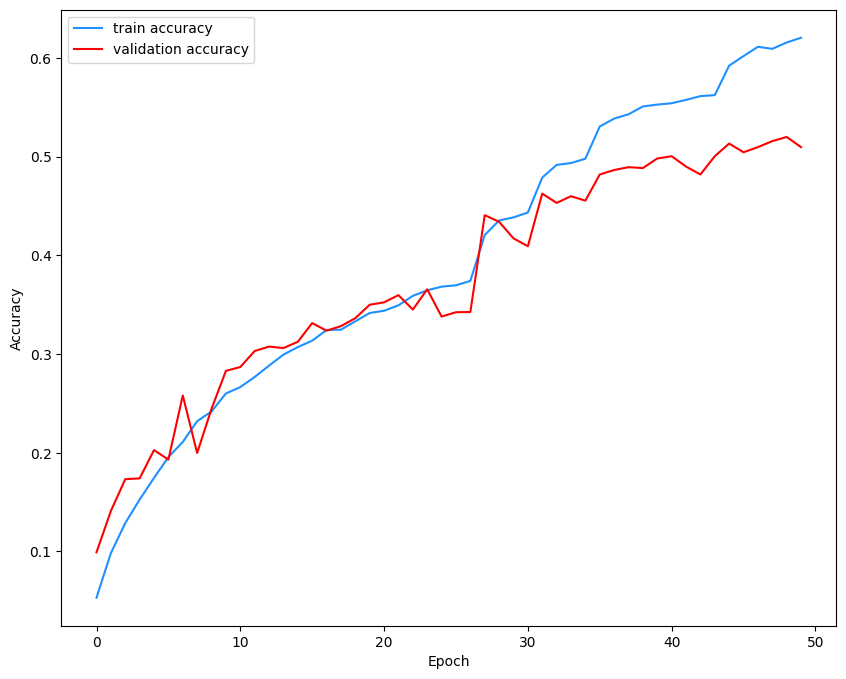

In [30]:
#Plot the training and validation accuracies
plt.figure(figsize=(10,8))
plt.plot(H.history['dense_4_accuracy'], label='train accuracy', color='dodgerblue')  #Replace 'dense_accuracy' with the actual key from H.history
plt.plot(H.history['val_dense_4_accuracy'], label='validation accuracy', color='red') #Replacing again
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

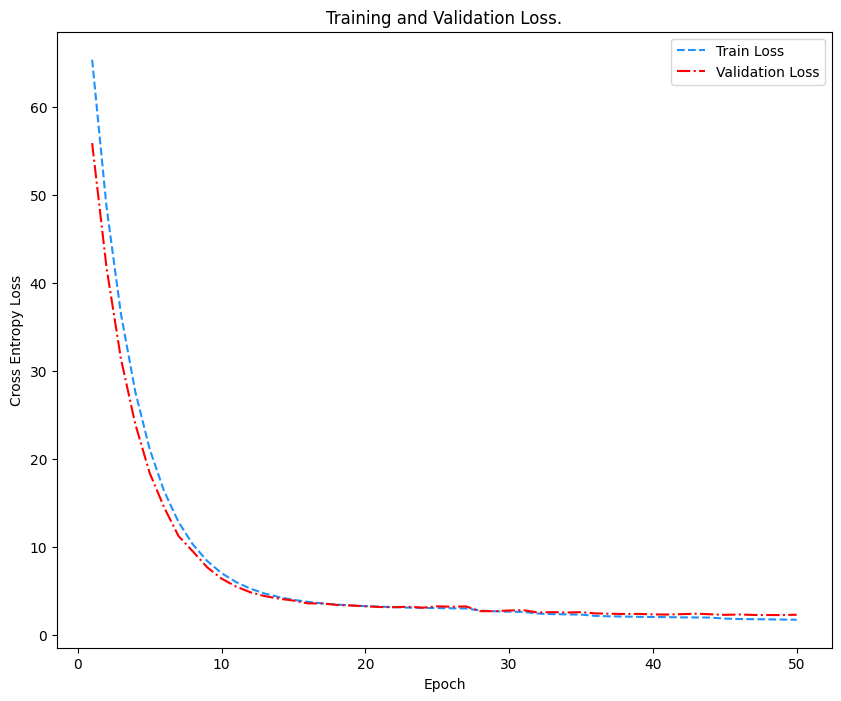

In [31]:
#Plot of the training loss (green line) and the validation loss (blue line)
plt.figure(figsize=(10,8))
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.plot(range(1, len(H.history['loss']) + 1), H.history['loss'], 
         label="Train Loss", linestyle="--", c="dodgerblue")
plt.plot(range(1, len(H.history['val_loss']) + 1), H.history['val_loss'], 
         label="Validation Loss", linestyle="-.", c="red")
plt.title("Training and Validation Loss.")
plt.legend()
plt.show()

### Metrics:
- $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
- $\text{Precision} = \frac{TP}{TP + FP}$
- $\text{Recall} = \frac{TP}{TP + FN}$
- $\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

Important:
- **Y_pred** is a list of arrays because the model has multiple outputs.
- **Y_pred[0]** regards the main output (not the auxiliary ones!).

Here it is not calculated the Confusion Matrix, since we have a lot of classes. It is used to evaluate the classification performance of the trained model on the test set, and it helps identifying specific classes where the model may be underperforming or misclassifying. This matrix shows the true positives, false positives, false negatives, and true negatives for each class.

In [17]:
#Predicting the test set using the trained model.
Y_pred = model.predict(X_test)

#Extracting the predicted classes from the model's main output (first output).
Y_pred_classes = np.argmax(Y_pred[0], axis=1)  #Converting predicted probabilities to class indices.

#Converting the true labels from one-hot encoded format to class indices.
Y_true = np.argmax(Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [18]:
#Final metrics calculation
#Accuracy
accuracy = accuracy_score(Y_true, Y_pred_classes) #i.e. the accuracy of the last epoch

#Precision (mean on all the classes through 'macro)
precision = precision_score(Y_true, Y_pred_classes, average='macro')

#Recall (mean on all the classes through 'macro)
recall = recall_score(Y_true, Y_pred_classes, average='macro')

#F1-Score (mean on all the classes through 'macro)
f1 = f1_score(Y_true, Y_pred_classes, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Accuracy: 50.95%
Precision: 52.86%
Recall: 50.95%
F1-Score: 50.67%


## References:
- https://medium.com/@abheerchrome/inception-v1-architecture-explained-454b2eb66baf
- https://www.analyticsvidhya.com/blog/2021/06/build-inception-network-from-scratch-with-python/
- https://hackmd.io/@machine-learning/Bk-61Fo8U